# Traveling Salesman Problem with National Parks
In this notebook we will be solving the traveling salesman problem using US National Parks as the nodes. We will pick a random National Park as a starting point. We will then traverse all national parks by going to the nearest one and map the final route on a map.

This project covers the following topics (in no particular order):
- APIs
- JSON

I found DataQuest's [Introduction to Using APIs in Python](https://www.dataquest.io/blog/python-api-tutorial/) to be useful for learning how to use API/JSON in Python.

## Libraries

In [1]:
import pandas as pd # pandas datastructure for reading and manipulating data
import geopandas # used to create geographic maps
from shapely.geometry import Point # used to help with geometry (points and polygons)
import matplotlib.pyplot as plt
from geopy.distance import geodesic # used to help measure geographic distances
from geopy.geocoders import Nominatim # Used to convert place names/addresses to GPS coordinates
import requests # Used to make API requests
import json 
import time # used to delay API requests
import random

# Magic command to show plots in Jupyter
%matplotlib inline 

## Mine Data
We need a list of national parks and their GPS coordinates. To get a list of national parks, we can use the [National Park Services API](https://www.nps.gov/subjects/developer/api-documentation.htm) to mine the relevant data. We then want to convert the name of each park to it's GPS coordinates, this is called geocoding. [Nominatim](https://wiki.openstreetmap.org/wiki/Nominatim) is a service from OpenStreetMap (OSM) that allows us to geocode (and even reverse-geocode).

### Call Nation Park Service API
Below, I attempt to use one call to the NPS API to get all 507 parks, however I always received a 500 response from the server. This means that the server is not able to provide that much data in one response.

In [ ]:
APIKey_NPS = "SdabNsh4xI7eRkDJ2bYDiVLFw3ON91xLTroLainn"
endpoint = "https://developer.nps.gov/api/v1/parks?"

parameters = {"api_key":APIKey_NPS} # limit is arbitrary value larger than total number of parks
response = requests.get(endpoint, params=parameters)
print("response status code: " + str(response.status_code))
data = response.json() # Interpret bytes as JSON format and convert to a Python dict
print(data)


I was able to get around the above issue by making smaller requests to the API in a loop and building a list of the responses as we went along.

In [ ]:
APIKey_NPS = "SdabNsh4xI7eRkDJ2bYDiVLFw3ON91xLTroLainn"
endpoint = "https://developer.nps.gov/api/v1/parks?"
responseList = [] # store json responses in a list

for i in range(0,510, 10): # There are currently 507 parks return, but we need this loop to only get 10 at a time.
    parameters = {"api_key":APIKey_NPS, 'limit':'10', 'start':str(i)} # limit is arbitrary value larger than total number of parks
    response = requests.get(endpoint, params=parameters)
    print("request #" + str(i) + " response status code: " + str(response.status_code))
    data = response.json() # Interpret bytes as JSON format and convert to a Python dict
    responseList.append(data["data"])
    print("length of response list " + str(len(responseList)))

### Convert data to pandas DataFrame
Now we can convert the list of responses into a pandas DataFrame. We also store it as a pickle on the hard drive so we don't have to send requests to the sketchy NPS servers anymore.

In [ ]:
parks = pd.concat([pd.DataFrame(x) for x in responseList], ignore_index=True) # convert list of json objects to dataframe
parks = parks.drop_duplicates() # remove duplicate parks (since we requested 510 and there are only 507)
print(parks)
parks.to_pickle('all_park_data.pkl')

### Visualize data
Its important to know what the data looks like so we can do some quick plots. We can see that there are many different types of NPS designations and some overlap with eachother. There are seperate designations for 'National Park', 'National and State Parks', 'National Park & Preserve'. This makes it difficult to sort out the National Parks that may also have other designations.

In [ ]:
print(parks.columns)
print(parks.shape)

print (parks['designation'].value_counts())

nationalParks = parks[parks['fullName'].str.contains("National Park")]
print(nationalParks.shape)
print(nationalParks.fullName)

### Processing KML files
I found the [List of national parks of the United States](https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States) on Wikipedia. Included on this page was a KML file which will have the name and coordinates of each Nationa Park. I am curious how this list compares to the data pulled from the NPS API above.

In [27]:
import xmltodict

# Read KML file into a Python dict
with open('national_parks_list_wiki.kml') as fd:
    doc = xmltodict.parse(fd.read())

# KML Placemarks are stored as a list, so we can iterate over all of them
length = len(doc['kml']['Document']['Folder']['Placemark'])
#print(length) # The number of National Parks

dfParks = pd.DataFrame(columns=['Name','Point', 'Latitude', 'Longitude'])

for i in range(length):
    name = doc['kml']['Document']['Folder']['Placemark'][i]['name']

    rawCoords = doc['kml']['Document']['Folder']['Placemark'][i]['Point']['coordinates']
    coords = rawCoords.split(',') # convert string to list[Long,Lat]
    coordsFloat = [float(coords[0]), float(coords[1])] # remove height from coords and convert values to float
    point = Point(coordsFloat)

    dfParks = dfParks.append({'Name':name, 'Point':point, 'Longitude':coordsFloat[0], 'Latitude':coordsFloat[1]}, ignore_index=True)

# convert DataFrame to GeoDataFrame
gdfParks = geopandas.GeoDataFrame(dfParks, geometry='Point')
print gdfParks

                               Name                               Point  \
0                            Acadia    POINT (-68.20999999999999 44.35)   
1   National Park of American Samoa              POINT (-170.68 -14.25)   
2                            Arches               POINT (-109.57 38.68)   
3                          Badlands                POINT (-102.5 43.75)   
4                          Big Bend               POINT (-103.25 29.25)   
5                          Biscayne                POINT (-80.08 25.65)   
6      Black Canyon of the Gunnison               POINT (-107.72 38.57)   
7                      Bryce Canyon               POINT (-112.18 37.57)   
8                       Canyonlands                POINT (-109.93 38.2)   
9                      Capitol Reef                POINT (-111.17 38.2)   
10                 Carlsbad Caverns               POINT (-104.44 32.17)   
11                  Channel Islands               POINT (-119.42 34.01)   
12                       

### Map our National Parks for sanity check
We should now map the points that we have parsed to make sure that they make sense. This will also give us practice in mapping using GPS coordinates (Lat, Long).

Text(22,0.5,'Longitude')

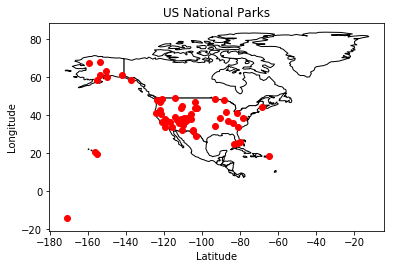

In [3]:
# Plot the coordinates over a country-level map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')  # restrict to North America
ax.set_title('US National Parks')
gdfParks.plot(ax=ax, color='red')
plt.xlabel('Latitude')
plt.ylabel('Longitude')



### Plot lines between all national park
Below we will test out plotly to easily plot lines between all national parks. Since our GeoDataFrame is in alphabetical order at this point, the lines will be drawn in this order. Later we can order our dataframe to match our Traveling Salesman solution route.

In [65]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='swampman', api_key='Rj1C8ZQfyjwR0QzKrYpI')

def get_route_lines(dfRoute, linecolor = 'rgba(66, 134, 244, 0.8)'):
    '''
    Generates route lines to be plotted on a geographical map with Plotly. 
    Input an ordered pandas dataframe containing columns: Name, Longitude, and Latitude.
    
    This function will build route lines between the points in the order they are indexed.
    '''
    
    route_lines = go.Scattergeo(
                lat = dfRoute[:]['Latitude'],
                lon = dfRoute[:]['Longitude'],
                mode='lines+markers+text',
                text=dfRoute[:]['Name'],
                textposition='top center',
                textfont=dict(
                    family='sans serif',
                    size=12,
                    color='black'
                ),
                marker = dict(
                    color = 'rgb(221, 97, 97)',
                    size = 8,
                    line = dict(
                        color = 'blue',
                        width = 1)
                ),
                line = go.scattergeo.Line(width = 2, color = linecolor)) 
    
    return route_lines


def get_layout(dfRoute, title=''):
    '''
    Generates a custom layout for plotting lines between geographic points in Plotly.
    '''
    # Find min/max Longitude/Lattitude so that we can bound our map in layout
    maxLat = max(dfRoute[:]['Latitude'])
    minLat = min(dfRoute[:]['Latitude'])
    maxLong = max(dfRoute[:]['Longitude'])
    minLong = min(dfRoute[:]['Longitude'])
    padding = 10 # how from min/max we should expand out
    
    layout = go.Layout(
        title = go.layout.Title(
            text = title
        ),
        showlegend = False,
        geo = go.layout.Geo(
            resolution = 50,
            showland = True,
            showlakes = True,
            landcolor = 'rgb(204, 204, 204)',
            countrycolor = 'rgb(204, 204, 204)',
            lakecolor = 'rgb(255, 255, 255)',
            projection = go.layout.geo.Projection(
                type = "equirectangular"
            ),
            coastlinewidth = 2,
            lataxis = go.layout.geo.Lataxis(
                range = [minLat-padding, maxLat+padding],
                showgrid = True,
                dtick = 10
            ),
            lonaxis = go.layout.geo.Lonaxis(
                range = [minLong-padding, maxLong+padding],
                showgrid = True,
                dtick = 20
            ),
        )
    )
    return layout
    
route_lines = get_route_lines(gdfParks)
layout = get_layout(gdfParks, 'Alphabetical Route to all US National Parks [Acadia to Zion]')

fig = go.Figure(data = [route_lines], layout = layout)
py.iplot(fig, filename = 'alphabetical-route-to-all-national-parks')

## Helper functions
These functions help solve the Traveling Salesman Problem using the greedy Nearest Neighbor approach.

In [6]:
def distance_between(location1, location2):
    '''Returns rounded integer of number of kilometers (km) between two locations on Earth'''
    
    #print(location1, location2)
    
    return round(geodesic((location1['Latitude'], location1['Longitude']),
                   (location2['Latitude'], location2['Longitude'])).km)


def find_nearest(location, list_of_neighbors):
    '''Returns a dict containing the original list Index, Name, and distance-to nearest neighbor'''

    if len(list_of_neighbors) is 0:
        return {'Index':None, 'Name': None, 'Distance': None}

    # Choose first neighbor to calculate distance
    currNeighbor = list_of_neighbors[0]
    minDistance = distance_between(location, currNeighbor)
    
    minIndex = 0


    for i in range(0,len(list_of_neighbors)): # start at index 1 because we already tested the 0 index neighbor
        currNeighbor = list_of_neighbors[i]
        currDistance = distance_between(location, currNeighbor)
        if currDistance < minDistance:
            minIndex = i
            minDistance = currDistance

    return {'Index':minIndex, 'Place': list_of_neighbors[minIndex], 'Distance':minDistance}

In [7]:
def greedy_nearest_neighbor_route(place, unvisited, costThreshold=-1):
    '''
    This function takes a place and a list of unvisited places.
    
    It returns the nearest neighbor route to all the unvisited places, as well as the overall
    cost of the route.
    
    The costThreshold parameter is optional and can be set to tell this function to give up
    if the overall cost of the route exceeds the threshold. In which case, the incomplete 
    cost and route will be returned.
    '''
    totalCost = 0
    route = []
    route.append(place)
    currLocation=place
    
    for i in range(len(unvisited)):
        nearest = find_nearest(currLocation, unvisited) # Note that the return value is not a place
        totalCost += nearest['Distance']
        route.append(nearest['Place'])
        del unvisited[nearest['Index']] # nearest is aware of it's index in unvisited
        currLocation = nearest['Place']
        
        # Give up on the route if minRouteCost is set and we exceeded the threshold
        if costThreshold > 0 and totalCost > costThreshold:
            return totalCost, route # return what we have so far, may be usefull for the caller

    return totalCost, route
        

### Solve Traveling Salesman with Nearest Neighbor (Greedy) Approach
Below we pick a random starting location and solve the Traveling Salesman Problem by always visiting the nearest neighbor. There are a few structures defined below to make this easier.


__Place:__ A dictionary will represent a place and contain {Name, Longitude, Latitude}. Really this could be any object with any coordinate system, not just geographic. If a different coordinate system were used, you would only need to modify the distance_between() function and the algorithm should work the same.

__Route:__ A list of places is used to represent the nearest neighbor route. The indexes (i) of the route will represent the order in which visitation should occur to replay the final route.
<br>Start Location: i = 0
<br>End Location: i = len(Route) - 1

__Unvisited:__ A list containing all of the unvisited places, excluding the one current place. Upon visiting a new place, we will measure the distance between all unvisited places within the list and then visit the one with minimum distance (cost).

In [82]:
unvisited = []

# Initialize unvisited List
for row in gdfParks.itertuples():
    place = {'Name':row.Name,
             'Latitude':row.Latitude,
             'Longitude':row.Longitude}
    unvisited.append(place)

# Choose start location and prepare to solve
randomInt = random.randint(0,len(unvisited))
randomInt = 52
place = unvisited.pop(randomInt)

cost, route = greedy_nearest_neighbor_route(place, unvisited, costThreshold=-1)

### What is the best starting location?
The above code is pretty okay, however the cost of the final route changes depending on the starting location. We can get the cost for every starting location and figure out which one is the best (and the worst). 

Note, this is when we begin to get processor intensive:
<br>
Outer Loop: O(n)
<br>
greedy_nearest_neighbor_route(): O(n)
<br>
find_nearest(): O(n/2)

#### Computational Complexity
$
\begin{align}
O( n^{3})
\end{align}
$


In [81]:
unvisitedOrig = []
startingLocations = pd.DataFrame(columns=['StartLocation', 'Route', 'NearestNeighborCost'])


# Initialize unvisited List
for row in gdfParks.itertuples():
    place = {'Name':row.Name,
             'Latitude':row.Latitude,
             'Longitude':row.Longitude}
    unvisitedOrig.append(place)

for i in range(len(unvisitedOrig)):
    
    unvisited = unvisitedOrig[:]
    place = unvisited.pop(i)
    cost, route = greedy_nearest_neighbor_route(place, unvisited, costThreshold=-1)
    print('Starting location ' + str(i) + ': ' + place['Name'] + ' (' + str(cost) + 'km)')
    startingLocations = startingLocations.append({'StartLocation':place['Name'], 'Route':route, 'NearestNeighborCost':cost}, ignore_index=True)

Starting location 0: Acadia (46313.0km)
Starting location 1: National Park of American Samoa (41378.0km)
Starting location 2: Arches (45343.0km)
Starting location 3: Badlands (43185.0km)
Starting location 4: Big Bend (42449.0km)
Starting location 5: Biscayne (44905.0km)
Starting location 6: Black Canyon of the Gunnison (45393.0km)
Starting location 7: Bryce Canyon (44818.0km)
Starting location 8: Canyonlands (45384.0km)
Starting location 9: Capitol Reef (44775.0km)
Starting location 10: Carlsbad Caverns (42648.0km)
Starting location 11: Channel Islands (43040.0km)
Starting location 12: Congaree (43794.0km)
Starting location 13: Crater Lake (44224.0km)
Starting location 14: Cuyahoga Valley (45300.0km)
Starting location 15: Death Valley (42928.0km)
Starting location 16: Denali (44365.0km)
Starting location 17: Dry Tortugas (44775.0km)
Starting location 18: Everglades (44998.0km)
Starting location 19: Gates of the Arctic (42178.0km)
Starting location 20: Gateway Arch (44883.0km)
Starting 

### Plotting multiple routes on map
We now have the nearest neighbor routes for every starting location! Let's plot these all on one map and see if we notice any patters. We will turn the opacity of the lines down so that we can see when the lines overlap.

In [84]:
route_lines1 = get_route_lines(pd.DataFrame(startingLocations.iloc[41]['Route']), linecolor='rgba(200, 244, 66, 0.5)')
route_lines2 = get_route_lines(pd.DataFrame(startingLocations.iloc[1]['Route']), linecolor='rgba(25, 0, 255, 0.5)')
layout = get_layout(pd.DataFrame(startingLocations.iloc[0]['Route']), 'Multiple Nearest Neighbor Routes to US National Parks (various starting locations)')

              
fig = go.Figure(data = [route_lines1,route_lines2], layout = layout)
py.iplot(fig, filename = 'stacked-route-to-all-national-parks')

In [85]:
route_lines1 = get_route_lines(pd.DataFrame(startingLocations.iloc[41]['Route']), linecolor='blue')
#route_lines2 = get_route_lines(pd.DataFrame(startingLocations.iloc[1]['Route']), linecolor='rgba(25, 0, 255, 0.5)')
layout = get_layout(pd.DataFrame(startingLocations.iloc[0]['Route']), 'Multiple Nearest Neighbor Routes to US National Parks (various starting locations)')

              
fig = go.Figure(data = [route_lines1], layout = layout)
py.iplot(fig, filename = 'best-starting-pints-route-to-all-national-parks')

In [80]:
route_lines = []

for i in range(len(startingLocations)):
    currLines = get_route_lines(pd.DataFrame(startingLocations.iloc[i]['Route']), linecolor='rgba(25, 0, 255, 0.025)')
    route_lines.append(currLines)
layout = get_layout(pd.DataFrame(startingLocations.iloc[0]['Route']), 'Nearest Neighbor Routes to US National Parks (all starting locations)')

fig = go.Figure(data = route_lines, layout = layout)
py.iplot(fig, filename = 'nearest-neighbor-routes-to-all-national-parks-all-starting-points')

In [19]:
route = []
unvisited = []

# Initialize unvisited List
for row in gdfParks.itertuples():
    place = {'Name':row.Name,
             'Latitude':row.Latitude,
             'Longitude':row.Longitude}
    unvisited.append(place)

print(unvisited[0:5])
# Choose start location and prepare to solve
currLocation = unvisited.pop(2)

for i in range(len(unvisited)): # Use index loop because unvisited[] will be modified upon each iteration
    nearest = find_nearest(location=currLocation, list_of_neighbors=unvisited)
    currLocation.update( {'Distance': nearest['Distance']} ) # Add Distance to dictionary
    route.append(currLocation)
    del unvisited[nearest['Index']]
    currLocation = nearest['Place']

# Append final location with distance of 0
currLocation.update( {'Distance': 0} ) # Add Distance to dictionary
route.append(currLocation)

# Merge results in original DataFrame
dfRoute = pd.DataFrame(route)
dfRoute['Visit_Order'] = dfRoute.index
gdfShortestParks = gdfParks.merge(dfRoute.set_index('Name'))
gdfShortestParks = gdfShortestParks.sort_values('Visit_Order')

print(gdfShortestParks.loc[:,['Name','Visit_Order']])

[{'Latitude': 44.35, 'Name': u'Acadia', 'Longitude': -68.21}, {'Latitude': -14.25, 'Name': u'National Park of American Samoa', 'Longitude': -170.68}, {'Latitude': 38.68, 'Name': u'Arches', 'Longitude': -109.57}, {'Latitude': 43.75, 'Name': u'Badlands', 'Longitude': -102.5}, {'Latitude': 29.25, 'Name': u'Big Bend', 'Longitude': -103.25}]
                               Name  Visit_Order
2                            Arches            0
8                       Canyonlands            1
9                      Capitol Reef            2
7                      Bryce Canyon            3
60                             Zion            4
23                     Grand Canyon            5
46                 Petrified Forest            6
42                       Mesa Verde            7
6      Black Canyon of the Gunnison            8
26                 Great Sand Dunes            9
49                   Rocky Mountain           10
56                        Wind Cave           11
3                       

### Plot Shortest Route To All US National Parks

In [ ]:
route_lines, layout = plot_route(gdfShortestParks, 
                                'Shortest Route to all US National Parks')
fig = go.Figure(data = route_lines, layout = layout)
py.iplot(fig, filename = 'shortest-route-to-all-national-parks')